In [ ]:
meetshah1995/pytorch-semseg
qubvel/segmentation_models
fast.ai

### load json

In [3]:
## TODO: Add mkdir if !path

In [1]:
from pathlib import Path
path = Path("/home/msadmin/.fastai/data/ubir-wurrkeng")
path_lbl = path/'labels'
path_img = path/'images'

#### Run next section once to download images/masks

In [11]:
import os
import json
import requests
import io

In [12]:
export_file_path = os.path.join(path, 'export.json')

In [13]:
from PIL import Image
# read export json and download mask images
with open(export_file_path, 'r') as export_file:
    data = json.load(export_file)
    for row in data:
        for object in row['Label']['objects']:
            response = requests.get(object['instanceURI'])
            image = Image.open(io.BytesIO(response.content))
            #image = image.convert("RGB")
            image.save(os.path.join(path_lbl, '{0}_{1}.png'.format(row['ID'].split('.')[0], object['value'])))

In [14]:
from PIL import Image
# export.json also contains images that haven't been labelled, so just pick out images with labels
with open(export_file_path, 'r') as export_file:
    data = json.load(export_file)
    for row in data:
        if row['Label']['objects']:
            for object in row['Label']['objects']:
                if object['value'] == 'para_grass':
                    print(row['ID']+'.jpeg')

ck1yg9h8gva1o0721m85ukssu.jpeg
ck1yg9h8gva1o0721m85ukssu.jpeg
ck1yog2hygucy07256xs98drv.jpeg
ck1yojtfdgup80725uuo4oiqj.jpeg
ck1yojtfdgup80725uuo4oiqj.jpeg
ck1yotq9jw5kh07211w9k9w4w.jpeg
ck1yotq9jw5kh07211w9k9w4w.jpeg
ck1yov0oxn8o90748a7c2wqo8.jpeg
ck1yp29ijqgot0838mr3kkm7f.jpeg
ck1yp41butfi10944auf37xe9.jpeg
ck1ypbzl2na9507484olijdl8.jpeg
ck1ypbzl2na9507484olijdl8.jpeg
ck1ypcv5kqhrs0838d8dn5tzs.jpeg
ck208xucpnmr90811blh8dzu8.jpeg
ck20958oi0zbe0748vb5mp7lw.jpeg
ck209bevw2ip007949xq07kqj.jpeg
ck209bevw2ip007949xq07kqj.jpeg
ck209fphna0na0721ut5ieqod.jpeg
ck209fphna0na0721ut5ieqod.jpeg
ck209jed02rum0794jl8quh09.jpeg
ck209lbvxbgug07576gxmei7k.jpeg
ck209r8hiogvh08110ykea61n.jpeg
ck209xarovch60725ynuoquq9.jpeg
ck20a181f58v90838fnyivr2d.jpeg
ck20a2ibm26ug0748lmmj67h5.jpeg
ck20a51j62bns07486gszqu4u.jpeg
ck20a8740vw1i07250xqts4rn.jpeg
ck20aa442vzq90725e863q7ti.jpeg
ck20ac5oj45da07949r93zda2.jpeg
ck20ae3602oe70748zh6mmz90.jpeg
ck20af3fq2oyl0748klzpz874.jpeg
ck20ajtrvbe3i0721te1kuu1l.jpeg
ck20alzr

In [15]:
from PIL import Image
## single class hack
# read export json and download mask images for para_grass
with open(export_file_path, 'r') as export_file:
    data = json.load(export_file)
    for row in data:
        for object in row['Label']['objects']:
            response = requests.get(object['instanceURI'])
            image = Image.open(io.BytesIO(response.content))
            image = image.convert("RGB")
            if object['value'] == 'para_grass':
                image.save(os.path.join(path_lbl, '{0}_P.jpeg'.format(row['ID'].split('.')[0])))

In [1]:
#### maybe merge to bring separate masks together

In [ ]:
import os
import numpy as np
from itertools import izip
from argparse import ArgumentParser
from collections import OrderedDict
from skimage.io import ImageCollection, imsave
from skimage.transform import resize


camvid_colors = OrderedDict([
    ("para_grass", np.array([255, 128, 0], dtype=np.uint8)),
    ("lily", np.array([255, 128, 0], dtype=np.uint8)),
    ("water", np.array([255, 255, 0], dtype=np.uint8)),
    ("other_grass", np.array([42, 0, 255], dtype=np.uint8)),
    ("bare_ground", np.array([212, 255, 0], dtype=np.uint8)),
    ("wet_para_grass", np.array([255, 0, 0], dtype=np.uint8)),
    ("dense_para_grass", np.array([255, 0, 0], dtype=np.uint8))    
])


def convert_label_to_grayscale(im):
    out = (np.ones(im.shape[:2]) * 255).astype(np.uint8)
    for gray_val, (label, rgb) in enumerate(camvid_colors.items()):
        match_pxls = np.where((im == np.asarray(rgb)).sum(-1) == 3)
        out[match_pxls] = gray_val
    assert (out != 255).all(), "rounding errors or missing classes in camvid_colors"
    return out.astype(np.uint8)


def make_parser():
    parser = ArgumentParser()
    parser.add_argument(
        'label_dir',
        help="Directory containing all RGB camvid label images as PNGs"
    )
    parser.add_argument(
        'out_dir',
        help="""Directory to save grayscale label images.
        Output images have same basename as inputs so be careful not to
        overwrite original RGB labels""")
    return parser


if __name__ == '__main__':
    parser = make_parser()
    args = parser.parse_args()
    labs = ImageCollection(os.path.join(args.label_dir, "*"))
    os.makedirs(args.out_dir)
    for i, (inpath, im) in enumerate(izip(labs.files, labs)):
        print i + 1, "of", len(labs)
        # resize to caffe-segnet input size and preserve label values
        resized_im = (resize(im, (360, 480), order=0) * 255).astype(np.uint8)
        out = convert_label_to_grayscale(resized_im)
        outpath = os.path.join(args.out_dir, os.path.basename(inpath))
        imsave(outpath, out)

In [5]:
#### end download treatment

## Image segmentation with UNet/HealthyHabitat

In [6]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [7]:
from fastai.vision import *
from fastai.callbacks.hooks import *
from fastai.utils.mem import *

## Data

In [8]:
fnames = get_image_files(path_img)
fnames[:3]

[PosixPath('/home/msadmin/.fastai/data/ubir-wurrkeng/images/ck20958oi0zbe0748vb5mp7lw.jpeg'),
 PosixPath('/home/msadmin/.fastai/data/ubir-wurrkeng/images/ck1yotq9jw5kh07211w9k9w4w.jpeg'),
 PosixPath('/home/msadmin/.fastai/data/ubir-wurrkeng/images/ck1yog2hygucy07256xs98drv.jpeg')]

In [9]:
lbl_names = get_image_files(path_lbl)
lbl_names[:3]

[PosixPath('/home/msadmin/.fastai/data/ubir-wurrkeng/labels/ck1yov0oxn8o90748a7c2wqo8_para_grass.png'),
 PosixPath('/home/msadmin/.fastai/data/ubir-wurrkeng/labels/ck20ac5oj45da07949r93zda2_P.jpeg'),
 PosixPath('/home/msadmin/.fastai/data/ubir-wurrkeng/labels/ck20a51j62bns07486gszqu4u_water.png')]

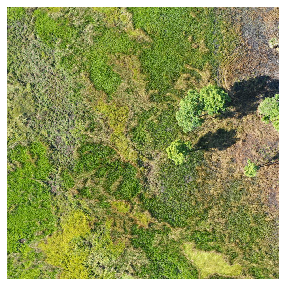

In [10]:
img_f = fnames[0]
img = open_image(img_f)
img.show(figsize=(5,5))

In [11]:
get_y_fn = lambda x: path_lbl/f'{x.stem}_P{x.suffix}'

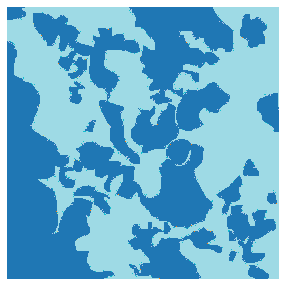

In [12]:
mask = open_mask(get_y_fn(img_f))
mask.show(figsize=(5,5), alpha=1)

In [13]:
src_size = np.array(mask.shape[1:])
src_size,mask.data

(array([1024, 1024]), tensor([[[  0,   0,   0,  ..., 255, 255, 255],
          [  0,   0,   0,  ..., 255, 255, 255],
          [  0,   0,   0,  ..., 255, 255, 255],
          ...,
          [  0,   0,   0,  ..., 255, 255, 255],
          [  0,   0,   0,  ..., 255, 255, 255],
          [  0,   0,   0,  ..., 255, 255, 255]]]))

In [14]:
codes = np.loadtxt(path/'codes_full.txt', dtype=str); codes

array(['bare_ground', 'burnt_para_grass', 'dead_para_grass', 'dense_para_grass', 'lily', 'other_grass', 'para_grass',
       'tree', 'water', 'wet_para_grass'], dtype='<U16')

## Datasets

In [15]:
size = src_size//2

free = gpu_mem_get_free_no_cache()
# the max size of bs depends on the available GPU RAM
if free > 8200: bs=8
else:           bs=4
print(f"using bs={bs}, have {free}MB of GPU RAM free")

using bs=8, have 11430MB of GPU RAM free


In [16]:
bs=4

In [ ]:
src = (SegmentationItemList.from_folder(path_img)
       .split_by_rand_pct()
       .label_from_func(get_y_fn, classes=codes))

In [ ]:
data = (src.transform(get_transforms(), size=size, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

In [ ]:
data.show_batch(2, figsize=(10,7))

In [ ]:
data.show_batch(2, figsize=(10,7), ds_type=DatasetType.Valid)

## Model

In [20]:
src.datasets(SegmentationDataset, classes=codes, div=True)

AttributeError: datasets

In [26]:
### Customer label due to labelbox using 0,255 Mask instead of 0,1,2,3
class SegLabelListCustom(SegmentationLabelList):
    def open(self, fn): return open_mask(fn, div=True)

class SegItemListCustom(SegmentationItemList):
    _label_cls = SegLabelListCustom

codes = ['0','1']

src = (SegItemListCustom.from_folder(path_img)
       .split_by_rand_pct()
       .label_from_func(get_y_fn, classes=codes))

data = (src.transform(get_transforms(), size=size, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

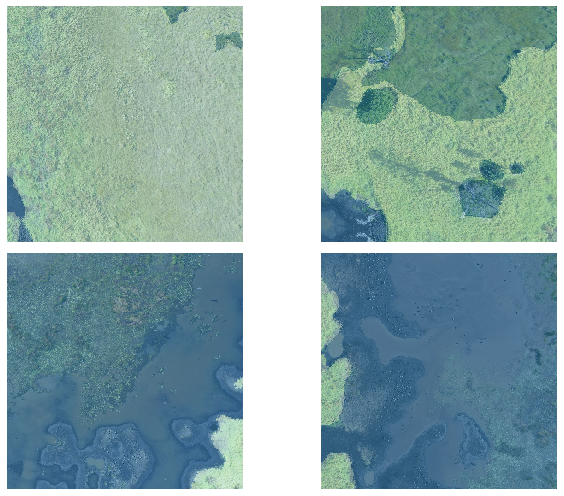

In [27]:
data.show_batch(2, figsize=(10,7))

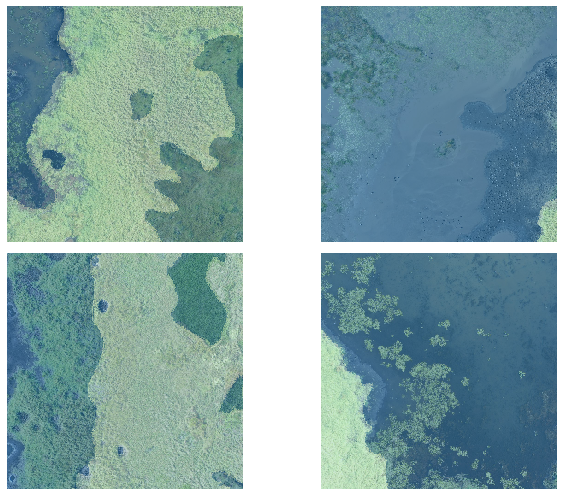

In [28]:
data.show_batch(2, figsize=(10,7), ds_type=DatasetType.Valid)

In [37]:
#metrics=acc_camvid
metrics=accuracy

In [38]:
wd=1e-2

In [57]:
#learn = unet_learner(data, models.resnet34, metrics=metrics, wd=wd)
learn = unet_learner(data, models.resnet34, wd=wd)

In [54]:
learn.model

DynamicUnet(
  (layers): ModuleList(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace)
      (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (4): Sequential(
        (0): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (1): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


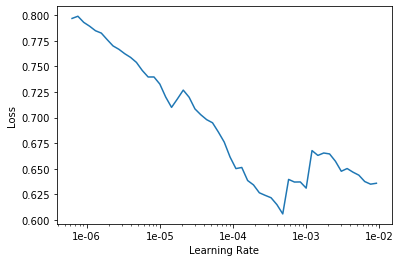

In [58]:
lr_find(learn)
learn.recorder.plot()

In [59]:
lr=1e-4

In [60]:
#learn.fit_one_cycle(10, slice(lr), pct_start=0.9)
learn.fit_one_cycle(3,1e-2)

epoch,train_loss,valid_loss,time
0,11.854512,1.099233,00:13
1,6.282896,0.690059,00:12
2,4.165782,0.581372,00:12


In [61]:
learn.save('stage-1')

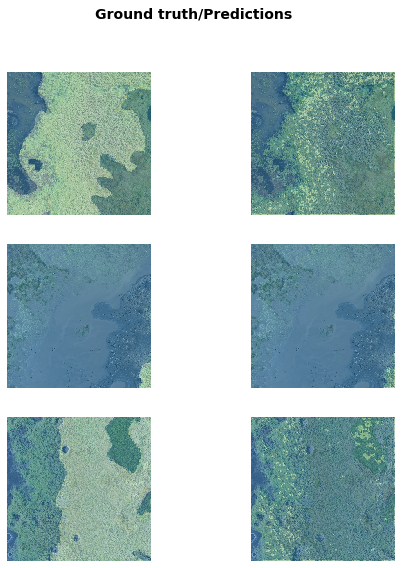

In [67]:
learn.show_results(rows=3, figsize=(8,9))

### Interpretation

In [62]:
from fastai.vision.interpret import SegmentationInterpretation
interp = SegmentationInterpretation.from_learner(learn)

In [63]:
# Since FlattenedLoss of CrossEntropyLoss() is used we reshape and then take the mean of pixel losses per image. 
# In order to do so we need to pass sizes:tuple to top_losses()
top_losses, top_idxs = interp.top_losses(sizes=(128,128))

(array([25.,  5.,  3.,  4.,  6.,  5.,  6., 13.,  7.,  6.]),
 array([0.006621, 0.139162, 0.271702, 0.404243, 0.536783, 0.669324, 0.801864, 0.934405, 1.066945, 1.199486, 1.332027],
       dtype=float32),
 <a list of 10 Patch objects>)

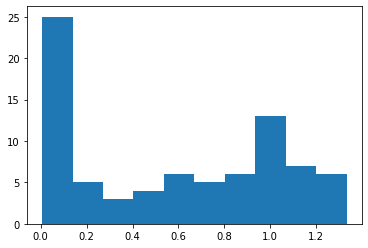

In [64]:
import matplotlib.pyplot as plt 
plt.hist(top_losses)

In [65]:
# Next, we can generate a confusion matrix similar to what we usually have for classification. 
# Two confusion matrices are generated: mean_cm which represents the global label performance 
#  and single_img_cm which represents the same thing but for each individual image in datase
learn.data.classes

['0', '1']

In [66]:
mean_cm, single_img_cm = interp._generate_confusion()

label,score
0,0.970758
1,0.146442


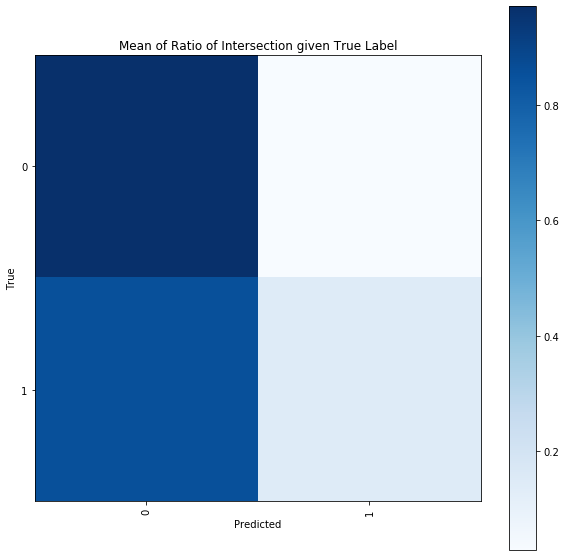

In [68]:
df = interp._plot_intersect_cm(mean_cm, "Mean of Ratio of Intersection given True Label")

label,score
0,0.976017
1,0.12256


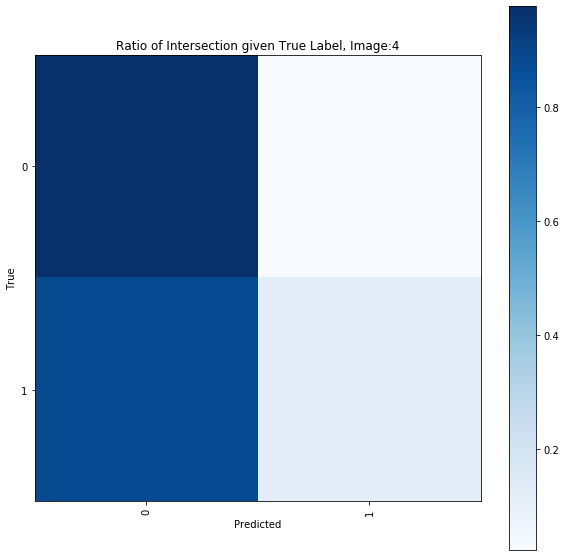

In [69]:
# look at the single worst prediction in our dataset
i = top_idxs[0]
df = interp._plot_intersect_cm(single_img_cm[i], f"Ratio of Intersection given True Label, Image:{i}")

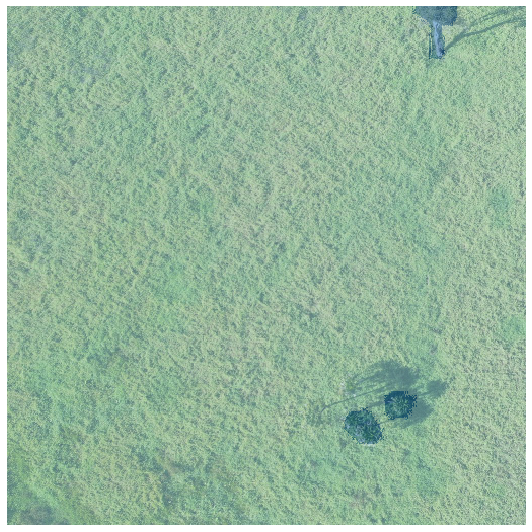

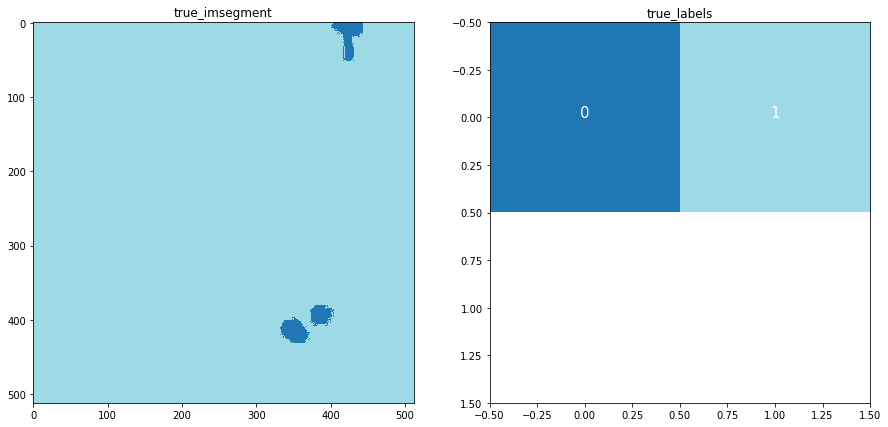

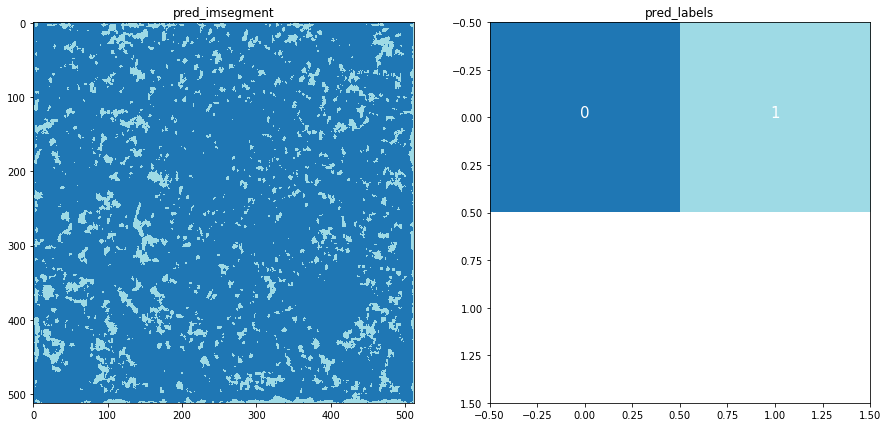

In [70]:
interp.show_xyz(i, sz=15)

### Continue training

In [71]:
learn.load('stage-1');

In [72]:
learn.unfreeze()

In [73]:
lrs = slice(lr/400,lr/4)

In [74]:
learn.fit_one_cycle(12, lrs, pct_start=0.8)

epoch,train_loss,valid_loss,time
0,0.433297,0.507550,00:14
1,0.452519,0.462024,00:12
2,0.444051,0.439568,00:12
3,0.457725,0.422872,00:12
4,0.451030,0.419325,00:12
5,0.443425,0.417638,00:12
6,0.444104,0.417639,00:12
7,0.444492,0.417354,00:12
8,0.445386,0.417295,00:12
9,0.443012,0.416395,00:12


In [ ]:
learn.save('stage-2');

## Go big

You may have to restart your kernel and come back to this stage if you run out of memory, and may also need to decrease `bs`.

In [ ]:
learn.destroy()

size = src_size

free = gpu_mem_get_free_no_cache()
# the max size of bs depends on the available GPU RAM
if free > 8200: bs=3
else:           bs=1
print(f"using bs={bs}, have {free}MB of GPU RAM free")

In [ ]:
data = (src.transform(get_transforms(), size=size, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

In [ ]:
learn = unet_learner(data, models.resnet34, metrics=metrics, wd=wd)

In [ ]:
learn.load('stage-2');

In [ ]:
lr_find(learn)
learn.recorder.plot()

In [ ]:
lr=1e-3

In [ ]:
learn.fit_one_cycle(10, slice(lr), pct_start=0.8)

In [ ]:
learn.save('stage-1-big')

In [ ]:
learn.load('stage-1-big');

In [ ]:
learn.unfreeze()

In [ ]:
lrs = slice(1e-6,lr/10)

In [ ]:
learn.fit_one_cycle(10, lrs)

In [ ]:
learn.save('stage-2-big')

In [ ]:
learn.load('stage-2-big');

In [ ]:
learn.show_results(rows=3, figsize=(10,10))